# Advanced RAG
![Advanced RAG](images/advanced_RAG_Diagram.png)

# Use Cases

![Use Cases](images/generated_ans_useCases.png)

In [79]:
import os
import umap
import chromadb
from pypdf import PdfReader
import matplotlib.pyplot as plt
from langchain_ollama import ChatOllama
from helper_utils import project_embeddings, word_wrap

In [16]:
reader = PdfReader("data/microsoft-annual-report.pdf")
pdf_texts = [p.extract_text().strip() for p in reader.pages]

#Filter the empty strings
pdf_texts = [text for text in pdf_texts if text]

In [17]:
print(
    word_wrap(
        pdf_texts[0],
        width=500,
    )
)

Dear shareholders, colleagues, customers, and partners,  
We are living through a time of historic challenge and opportunity. As I write this, the world faces ongoing economic, 
social, and geopolitical volatility. At the same time, we have entered a new age of AI that will fundamentally transform 
productivity for every individual, organization, and industry on earth, and help us address some of our most pressing 
challenges.  
This next generation of AI will reshape every software category and
 every business, including our own. Forty-eight years 
after its founding, Microsoft remains a consequential company because time and time again—from PC/Server, to Web/
Internet, to Cloud/Mobile—we have adapted to technological paradigm shifts. Today, we are doing so once again, as we 
lead this new era.  
Amid this transformation, our mission to empower every person and every organization on the planet to achieve 
more remains constant. As a company, we believe we can be the democratizing forc

# Split the text into smaller chunks

In [18]:
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    SentenceTransformersTokenTextSplitter,
)

character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""], chunk_size=1000, chunk_overlap=0
)
character_split_texts = character_splitter.split_text("\n\n".join(pdf_texts))

print(word_wrap(character_split_texts[10]))
print(f"\nTotal chunks: {len(character_split_texts)}")

Industry  
Across industries, we are rapidly becoming the partner of choice for any org
anization looking to generate real value from 
AI. In healthcare, for example, we intro
duced the world’s first fully automated clinical documentation application, DAX 
Copilo
t. The application helps physicians reduce documentation time by half, freeing them to 
spend more time face to 
face with patients. And Epic will integrate it directly into i
ts electronic health records system.  
And, in retail, we introduced new tools to help 
companies manage their day-to-day operations and digitize their physical 
stores.  
Mod
ern work  
We are rapidly evolving Microsoft 365 into an AI-first platform that enables
 every individual to amplify their creativity and 
productivity, with both our establis
hed applications like Office and Teams, as well as new apps like Designer, Stream, and 

Loop. Microsoft 365 is designed for today’s digitally connected, distributed workforce
.

Total chunks: 350


In [19]:
token_splitter = SentenceTransformersTokenTextSplitter(
chunk_overlap=0, tokens_per_chunk=256
)
token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

print(word_wrap(token_split_texts[10]))
print(f"\nTotal chunks: {len(token_split_texts)}")

industry across industries, we are rapidly becoming the partner of choice for any organ
ization looking to generate real value from ai. in healthcare, for example, we introduc
ed the world ’ s first fully automated clinical documentation application, dax copilot.
 the application helps physicians reduce documentation time by half, freeing them to sp
end more time face to face with patients. and epic will integrate it directly into its 
electronic health records system. and, in retail, we introduced new tools to help compa
nies manage their day - to - day operations and digitize their physical stores. modern 
work we are rapidly evolving microsoft 365 into an ai - first platform that enables eve
ry individual to amplify their creativity and productivity, with both our established a
pplications like office and teams, as well as new apps like designer, stream, and loop.
 microsoft 365 is designed for today ’ s digitally connected, distributed workforce.

Total chunks: 359


In [20]:
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()
#print(embedding_function([token_split_texts[10]]))

In [22]:
chroma_client = chromadb.Client()
chroma_collection = chroma_client.get_or_create_collection(
    "microsoft-collection", embedding_function=embedding_function
)

In [23]:
#extract the embeddings of the token_split_texts
ids = [str(i) for i in range(len(token_split_texts))]
chroma_collection.add(ids=ids, documents=token_split_texts)
count = chroma_collection.count()
print(count)

359


In [24]:
query = "What was the total revenue for the year?"
results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results["documents"][0]
for document in retrieved_documents:
    print (word_wrap(document))
    print("\n")

general and administrative $ 7, 575 $ 5, 900 28 % as a percent of revenue 4 % 3 % 1ppt 
35


segment revenue and operating income were as follows during the periods presented : no 
sales to an individual customer or country other than the united states accounted for m
ore than 10 % of revenue for fiscal years 2023, 2022, or 2021. revenue, classified by t
he major geographic areas in which our customers were located, was as follows : ( a ) i
ncludes billings to oems and certain multinational organizations because of the nature 
of these businesses and the impracticability of determining the geographic source of th
e revenue. ( in millions ) year ended june 30, 2023 2022 2021 revenue productivity and 
business processes $ 69, 274 $ 63, 364 $ 53, 915 intelligent cloud 87, 907 74, 965 59, 
728 more personal computing 54, 734 59, 941 54, 445 total $ 211, 915 $ 198, 270 $ 168, 
088 operating income productivity and business processes $ 34, 189 $ 29, 690 $ 24, 351 
intelligent cloud 37, 884 3

# Augment Query Generated by llm

In [28]:
client = ChatOllama(
    model = "llama3.1",
    temperature=0.0,
)

In [33]:
def augment_query_generated(query):
    prompt = """You are a helpful expert financial research assistant.
    Provide an example answer to the given question, that migh be found in a document like an annual report."""
    
    messages = [
    {"role": "system", "content": prompt},
    {"role": "user", "content": query},
    ]

    response = client.invoke(messages)
    return response.content

In [56]:
original_query = "What was the total profit for the year, and how does it compare to the previous year?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"

In [57]:
print(word_wrap(joint_query))

What was the total profit for the year, and how does it compare to the previous year? A
ccording to our company's latest annual report, here is the relevant information:

**To
tal Profit for the Year:**
Our consolidated net income for the fiscal year ended Decemb
er 31, 2022, was $1.23 billion.

**Comparison to Previous Year:**
This represents a 12%
 increase from the previous year's total profit of $1.10 billion, which was reported fo
r the fiscal year ended December 31, 2021.

Here is a breakdown of our net income for t
he past two years:

| Fiscal Year | Net Income (in millions) |
| --- | --- |
| 2022 | $
1,230 |
| 2021 | $1,100 |

As you can see, we have experienced significant growth in ou
r profit margins over the past year, driven by a combination of revenue increases and c
ost-saving initiatives. We are pleased with this progress and believe it reflects the e
ffectiveness of our business strategies and operational improvements.


In [58]:
results = chroma_collection.query(
    query_texts=joint_query, n_results=5, include=["documents", "embeddings"]
)
retrieved_documents = results["documents"][0]

for doc in retrieved_documents:
    print(word_wrap(doc))
    print("")

change in accounting estimate in july 2022, we completed an assessment of the useful li
ves of our server and network equipment. due to investments in software that increased 
efficiencies in how we operate our server and network equipment, as well as advances in
 technology, we determined we should increase the estimated useful lives of both server
 and network equipment from four years to six years. this change in accounting estimate
 was effective beginning fiscal year 2023. based on the carrying amount of server and n
etwork equipment included in property and equipment, net as of june 30, 2022, the effec
t of this change in estimate for fiscal year 2023 was an increase in operating income o
f $ 3. 7 billion and net income of $ 3. 0 billion, or $ 0. 40 per both basic and dilute
d share. reportable segments we report our financial performance based on the following
 segments : productivity and business processes, intelligent

( in millions ) year ended june 30, 2023 2022 2021 operati

# Plot Graph

In [59]:
embeddings = chroma_collection.get(include=["embeddings"])["embeddings"]
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)


retrieved_embeddings = results["embeddings"][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(
    original_query_embedding, umap_transform
)
projected_augmented_query_embedding = project_embeddings(
    augmented_query_embedding, umap_transform
)
projected_retrieved_embeddings = project_embeddings(
    retrieved_embeddings, umap_transform
)

C:\Users\theha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\theha\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\theha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\theha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\theha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarn

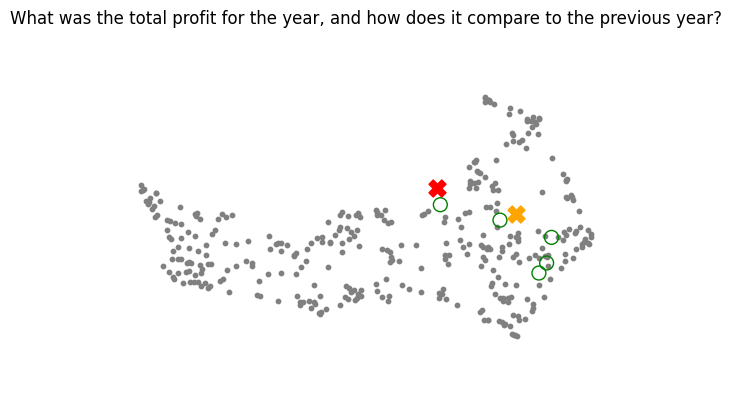

In [60]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()

plt.scatter(
    projected_dataset_embeddings[:, 0],
    projected_dataset_embeddings[:, 1],
    s=10,
    color="gray",
)
plt.scatter(
    projected_retrieved_embeddings[:, 0],
    projected_retrieved_embeddings[:, 1],
    s=100,
    facecolors="none",
    edgecolors="g",
)
plt.scatter(
    projected_original_query_embedding[:, 0],
    projected_original_query_embedding[:, 1],
    s=150,
    marker="X",
    color="r",
)
plt.scatter(
    projected_augmented_query_embedding[:, 0],
    projected_augmented_query_embedding[:, 1],
    s=150,
    marker="X",
    color="orange",
)

plt.gca().set_aspect("equal", "datalim")
plt.title(f"{original_query}")
plt.axis("off")
plt.show()  # display the plot

- Red X: Original query
- Yellow X: Augmented query
- Gray Dots: Are datasets embeddings
- Circles: Retrieved documents

You see the augmented query is close to the retrieved documents than the original query. Looking at it, you can see it is quite an improvement.


---

# Query Expansion with Multiple queries

![Advanced RAG](images/advanced_RAG_Diagram2.png)

# Use Cases

![Use Case](images/multiple_query_useCases.png)

In [67]:
def generate_multi_query(query):
    prompt = """
    You are a knowledgeable financial research assistant. 
    Your users are inquiring about an annual report. 
    For the given question, propose up to five related questions to assist them in finding the information they need. 
    Provide concise, single-topic questions (withouth compounding sentences) that cover various aspects of the topic. 
    Ensure each question is complete and directly related to the original inquiry. 
    List each question on a separate line without numbering.
    Do not include any introductory or explanatory text—only output the questions.
                """
    messages = [
        {"role": "system", "content": prompt,},
        {"role": "user", "content": query},
    ]

    response = client.invoke(messages)
    content = response.content
    content = content.split("\n")
    return content

In [70]:
original_query = (
    "What details can you provide about the factors that led to revenue growth?"
)

aug_queries = generate_multi_query(original_query)

for query in aug_queries:
    print("\n", query)


 What were the primary drivers of revenue increase in the past fiscal year?

 How did changes in market demand impact revenue growth for the company?

 Were there any significant new product or service launches that contributed to revenue expansion?

 Did the company experience any notable increases in customer base or retention rates during this period?

 To what extent did strategic partnerships or collaborations contribute to revenue growth?


In [71]:
#Concatenate the original query with the augmented queries
joint_query = [
    original_query
] + aug_queries

print("======> \n\n", joint_query)

======> 

 ['What details can you provide about the factors that led to revenue growth?', 'What were the primary drivers of revenue increase in the past fiscal year?', 'How did changes in market demand impact revenue growth for the company?', 'Were there any significant new product or service launches that contributed to revenue expansion?', 'Did the company experience any notable increases in customer base or retention rates during this period?', 'To what extent did strategic partnerships or collaborations contribute to revenue growth?']


In [74]:
results = chroma_collection.query(
    query_texts=joint_query, n_results=5, include=["documents", "embeddings"]
)
retrieved_documents = results["documents"]

#Filter unique documents only
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

In [75]:
#Output the results documents
for i, documents in enumerate(retrieved_documents):
    print(f"Query: {joint_query[i]}")
    print("")
    print("Results")
    for doc in documents:
        print(word_wrap(doc))
        print("")
    print("-" * 100)

Query: What details can you provide about the factors that led to revenue growth?

Results
sales and marketing expenses increased $ 934 million or 4 % driven by 3 points of growt
h from the nuance and xandr acquisitions and investments in commercial sales, offset in
 part by a decline in windows advertising. sales and marketing included a favorable for
eign currency impact of 2 %. general and administrative general and administrative expe
nses include payroll, employee benefits, stock - based compensation expense, employee s
everance expense incurred as part of a corporate program, and other headcount - related
 expenses associated with ( in millions, except percentages ) 2023 2022 percentage chan
ge research and development $ 27, 195 $ 24, 512 11 % as a percent of revenue 13 % 12 % 
1ppt ( in millions, except percentages ) 2023 2022 percentage change sales and marketin
g $ 22, 759 $ 21, 825 4 % as a percent of revenue 11 % 11 % 0ppt ( in millions, except 
percentages ) 2023 2022 perce

In [76]:
embeddings = chroma_collection.get(include=["embeddings"])["embeddings"]
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

# 4. We can also visualize the results in the embedding space
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(joint_query)


project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(
    augmented_query_embeddings, umap_transform
)

retrieved_embeddings = results["embeddings"]
result_embeddings = [item for sublist in retrieved_embeddings for item in sublist]

projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

C:\Users\theha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\theha\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\theha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\theha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\theha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarn

In [77]:
plt.close()  # Close the figure completely

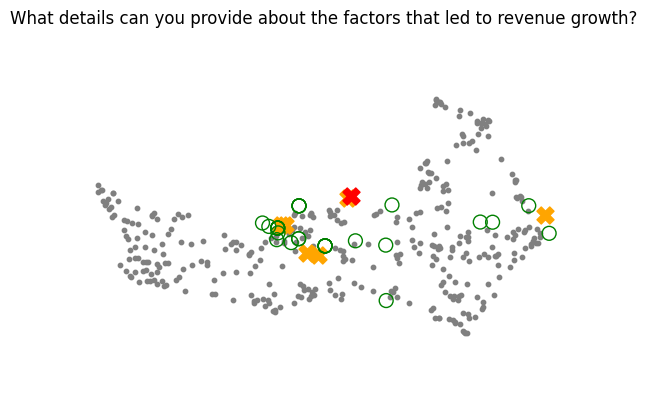

In [78]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(
    projected_dataset_embeddings[:, 0],
    projected_dataset_embeddings[:, 1],
    s=10,
    color="gray",
)
plt.scatter(
    project_augmented_queries[:, 0],
    project_augmented_queries[:, 1],
    s=150,
    marker="X",
    color="orange",
)
plt.scatter(
    projected_result_embeddings[:, 0],
    projected_result_embeddings[:, 1],
    s=100,
    facecolors="none",
    edgecolors="g",
)
plt.scatter(
    project_original_query[:, 0],
    project_original_query[:, 1],
    s=150,
    marker="X",
    color="r",
)

plt.gca().set_aspect("equal", "datalim")
plt.title(f"{original_query}")
plt.axis("off")
plt.show()  # display the plot